# Handling data

In this notebook we are going to see how to read IllustrisTNG data and see the
main aspects that we are going to use from this, as a dataset, for the machine
learning session.

We are going to work with **IllustrisTNG** halo/galaxy catalog, from [**CAMELS**](https://camels.readthedocs.io/en/latest/). A complete description of the data, as well other user instructions is given in the [webpage](https://camels.readthedocs.io/en/latest/subfind.html).

## 0) Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

## 1) Reading the data

The **IllustrisTNG** data is a `.hdf5` file. We can read their content using the library `h5py`, using the `keys` method

In [2]:
f = h5py.File('../data/fof_subhalo_tab_033.hdf5')
f.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

The catalog specs are given by:

In [3]:
BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = f['Header'].attrs[u'Time']           #scale factor
h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [4]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work with both (halos and galaxies). So, le't get some of their properties

In [5]:
c = 3.*10**8

# Positions, velocities and masses of the halos
M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
V_h  =  f['Group/GroupVel'][:]                  #km/s
V_h =   np.linalg.norm(V_h, axis = 1)
ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

# Positions, stellar masses,  of the galaxies
M_g    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
color_g = f['Subhalo/SubhaloStellarPhotometrics'][:]
color_g = color_g[:, 4] - color_g[:, 6]
SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
BH_g   = f['Subhalo/SubhaloBHMass'][:]*1e10     #Msun/h
ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

# close file
f.close()

In [6]:
M_h.shape, M_g.shape

((20131,), (17176,))

Taking only the halos which have galaxies

In [7]:
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Creating the halo and galaxy catalogs

In [8]:
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(5)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0
3,1.533784e+13,0.000001,29.311657,3.0
4,1.587606e+13,0.000001,201.305161,4.0


In [9]:
data = np.array( [ M_g, color_g, SFR, BH_g, ID_g ] ).T
columns = [ 'M_g', 'color_g', 'SFR_g', 'BH_g', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(5)

,M_g,color_g,SFR_g,BH_g,ID
0,4.267894e+11,1.126476,0.000000e+00,1.894081e+09,0.0
1,2.398532e+10,0.826265,1.699688e+10,3.817824e+07,0.0
2,1.551164e+10,0.798616,2.204744e+09,5.217522e+07,0.0
3,1.581151e+10,0.948381,3.712553e+09,8.508270e+07,0.0
4,1.514770e+09,0.460390,5.606419e+09,1.227756e+06,0.0


Keeping only central galaxies

In [10]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

Matching the catalogs

In [11]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df.shape

(13837, 8)

Cleaning the data

In [12]:
df = df[ df['M_g'] > 0 ] #Considering only galaxies
df['SFR_g'] = df['SFR_g'].replace(0, 1)
df['SFR_g'] = np.log10(df['SFR_g'])
df.loc[df['SFR_g'] == 0, "SFR_g"] = np.random.normal(7, 0.5, len(df.loc[df["SFR_g"] == 0]))
df.shape

(1514, 8)

In [13]:
df.describe()

,M_h,R_h,V_h,ID,M_g,color_g,SFR_g,BH_g
count,1.514000e+03,1.514000e+03,1514.000000,1514.000000,1.514000e+03,1514.000000,1514.000000,1.514000e+03
mean,2.590867e+11,2.269759e-07,159.914377,1107.276090,3.018712e+09,0.678903,7.629928,1.211282e+07
std,1.656051e+12,1.490707e-07,84.731841,1308.501707,1.944717e+10,0.192099,1.047514,8.101873e+07
min,1.443876e+09,6.127277e-08,7.104222,0.000000,1.739187e+06,-0.794176,5.610056,0.000000e+00
25%,2.201826e+10,1.519423e-07,100.411592,378.250000,1.297332e+07,0.638956,6.866994,0.000000e+00
50%,4.039674e+10,1.860214e-07,144.193092,787.500000,3.437585e+07,0.700603,7.356710,8.002207e+05
75%,9.681791e+10,2.489396e-07,204.188789,1373.750000,2.047698e+08,0.764560,8.289084,8.230829e+05
max,4.500575e+13,1.928402e-06,563.310913,17953.000000,4.267894e+11,1.197241,10.718828,1.894081e+09


Data-preprocessing

In [14]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])

df['M_g'] = np.log10(df['M_g'])

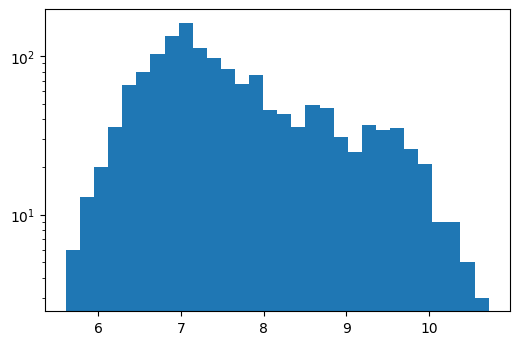

In [15]:
plt.figure(dpi = 100)
plt.hist(df['SFR_g'], bins = 30)
plt.yscale('log')